<a href="https://colab.research.google.com/github/Bhubanghimire/image-caption-generation-web-deployment/blob/master/image_annotation_final_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://developer.nvidia.com/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64-deb
!dpkg -i cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64-deb
!apt-key add /var/cuda-repo-9-0-local/7fa2af80.pub
!apt-get update
!apt-get install cuda=9.0.176-1

In [6]:
!pip3 install tensorflow-gpu==1.12.0
import tensorflow as tf
print(tf.__version__)

     |████████████████████████████████| 281.7MB 61kB/s 
     |████████████████████████████████| 3.1MB 40.2MB/s 
     |████████████████████████████████| 51kB 5.4MB/s 
ERROR: tensorflow 2.4.1 has requirement tensorboard~=2.4, but you'll have tensorboard 1.12.2 which is incompatible.
ERROR: fancyimpute 0.4.3 has requirement keras>=2.0.0, but you'll have keras 1.2.2 which is incompatible.
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1


2.4.1


In [78]:
!pip3 install keras

In [1]:
import tensorflow as tf
from tensorflow.python.client import device_lib
device_lib.list_local_devices()
print(tf.__version__)

2.4.1


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from tqdm import tqdm
import pandas as pd
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,  Activation, Flatten
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
import nltk

In [5]:
token ='/content/drive/My Drive/dataset/Flickr8k/Flickr8k_text/Flickr8k.token.txt'

In [6]:
captions = open(token, 'r').read().strip().split('\n')

In [7]:
d = {}
for i, row in enumerate(captions):
    row = row.split('\t')
    row[0] = row[0][:len(row[0])-2]
    if row[0] in d:
        d[row[0]].append(row[1])
    else:
        d[row[0]] = [row[1]]

In [8]:
d['1000268201_693b08cb0e.jpg']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [9]:
images = '/content/drive/My Drive/dataset/Flickr8k/Flickr8k_Dataset/Flicker8k_Dataset/'

In [10]:
img = glob.glob(images+'*.jpg')

In [11]:
img[:5]

['/content/drive/My Drive/dataset/Flickr8k/Flickr8k_Dataset/Flicker8k_Dataset/1801874841_4c12055e2f.jpg',
 '/content/drive/My Drive/dataset/Flickr8k/Flickr8k_Dataset/Flicker8k_Dataset/1335617803_4fbc03dab0.jpg',
 '/content/drive/My Drive/dataset/Flickr8k/Flickr8k_Dataset/Flicker8k_Dataset/1394927474_0afdd82fc4.jpg',
 '/content/drive/My Drive/dataset/Flickr8k/Flickr8k_Dataset/Flicker8k_Dataset/2272750492_91e8f67328.jpg',
 '/content/drive/My Drive/dataset/Flickr8k/Flickr8k_Dataset/Flicker8k_Dataset/3355756569_b430a29c2a.jpg']

In [12]:
train_images_file = '/content/drive/My Drive/dataset/Flickr8k/Flickr8k_text/Flickr_8k.trainImages.txt'

In [13]:
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

In [14]:
def split_data(l):
    temp = []
    for i in img:
        if i[len(images):] in l:
            temp.append(i)
    return temp

In [15]:
# Getting the training images from all the images
train_img = split_data(train_images)
len(train_img)

6000

In [16]:
val_images_file = '/content/drive/My Drive/dataset/Flickr8k/Flickr8k_text/Flickr_8k.devImages.txt'
val_images = set(open(val_images_file, 'r').read().strip().split('\n'))

In [17]:
# Getting the validation images from all the images
val_img = split_data(val_images)
len(val_img)

1000

In [18]:
test_images_file = '/content/drive/My Drive/dataset/Flickr8k/Flickr8k_text/Flickr_8k.testImages.txt'
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

In [19]:
# Getting the testing images from all the images
test_img = split_data(test_images)
len(test_img)

1000

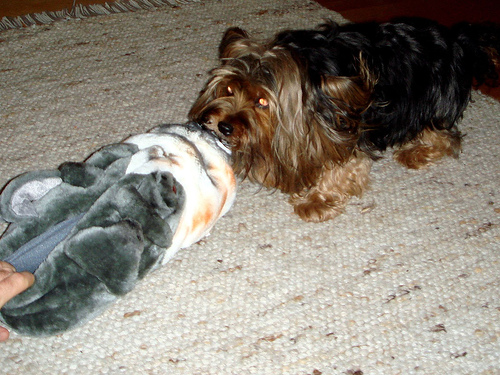

In [20]:
Image.open(train_img[0])

In [21]:
def preprocess_input(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x

In [22]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    x = preprocess_input(x)
    return x

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


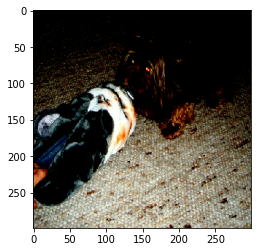

In [23]:
plt.imshow(np.squeeze(preprocess(train_img[0])))

In [24]:

model = InceptionV3(weights='imagenet')

In [25]:

from keras.models import Model

new_input = model.input
hidden_layer = model.layers[-2].output

model_new = Model(new_input, hidden_layer)

In [26]:
tryi = model_new.predict(preprocess(train_img[0]))

In [27]:
tryi.shape

(1, 2048)

In [28]:
def encode(image):
    image = preprocess(image)
    temp_enc = model_new.predict(image)
    temp_enc = np.reshape(temp_enc, temp_enc.shape[1])
    return temp_enc

In [ ]:
encoding_train = {}
for img in tqdm(train_img):
    encoding_train[img[len(images):]] = encode(img)

  4%|▍         | 257/6000 [02:27<57:36,  1.66it/s]

In [ ]:
with open("/content/drive/My Drive/Colab Notebooks/encoded_images_inceptionV3_for_new.p", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle) 

In [29]:
encoding_train = pickle.load(open('/content/drive/My Drive/Colab Notebooks/encoded_images_inceptionV3.p', 'rb'))

In [30]:
encoding_train['3556792157_d09d42bef7.jpg'].shape

(2048,)

In [ ]:
encoding_test = {}
for img in tqdm(test_img):
    encoding_test[img[len(images):]] = encode(img)

100%|██████████| 1000/1000 [09:24<00:00,  1.77it/s]


In [ ]:
with open("/content/drive/My Drive/Colab Notebooks/encoded_images_test_inceptionV3_for_new.p", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle) 

In [31]:
encoding_test = pickle.load(open('/content/drive/My Drive/Colab Notebooks/encoded_images_test_inceptionV3.p', 'rb'))

In [32]:
encoding_test[test_img[0][len(images):]].shape

(2048,)

In [33]:
train_d = {}
for i in train_img:
    if i[len(images):] in d:
        train_d[i] = d[i[len(images):]]

In [34]:
len(train_d)

6000

In [35]:
train_d[images+'3556792157_d09d42bef7.jpg']

['A bunch of children sitting in chairs and standing on wooden floors .',
 'A group of children sit , stand , and kneel along a wall .',
 'A group of children sitting on folding chairs and playing .',
 'a young group of children sitting in a row against the wall .',
 'The kids talking while sitting on a row of chairs along the wall .']

In [36]:
val_d = {}
for i in val_img:
    if i[len(images):] in d:
        val_d[i] = d[i[len(images):]]

In [37]:
len(val_d)

1000

In [38]:
test_d = {}
for i in test_img:
    if i[len(images):] in d:
        test_d[i] = d[i[len(images):]]

In [39]:
len(test_d)

1000

In [40]:
caps = []
for key, val in train_d.items():
    for i in val:
        caps.append('<start> ' + i + ' <end>')

In [41]:
words = [i.split() for i in caps]

In [42]:
unique = []
for i in words:
    unique.extend(i)

In [43]:
unique = list(set(unique))

In [44]:
 with open("/content/drive/My Drive/Colab Notebooks/models/unique.p", "wb") as pickle_d:
     pickle.dump(unique, pickle_d) 

In [45]:
unique = pickle.load(open('/content/drive/My Drive/Colab Notebooks/models/unique.p', 'rb'))

In [46]:
len(unique)

8256

In [47]:
word2idx = {val:index for index, val in enumerate(unique)}

In [48]:
word2idx['<start>']

795

In [49]:
idx2word = {index:val for index, val in enumerate(unique)}

In [50]:
idx2word[5553]

'poem'

Calculating the maximum length among all the captions

In [51]:
max_len = 0
for c in caps:
    c = c.split()
    if len(c) > max_len:
        max_len = len(c)
max_len

40

In [52]:
len(unique), max_len

(8256, 40)

In [53]:
vocab_size = len(unique)

In [54]:
vocab_size

8256

In [55]:
f = open('flickr8k_training_dataset.txt', 'w')
f.write("image_id\tcaptions\n")

18

In [56]:
for key, val in train_d.items():
    for i in val:
        f.write(key[len(images):] + "\t" + "<start> " + i +" <end>" + "\n")

f.close()

In [57]:
df = pd.read_csv('flickr8k_training_dataset.txt', delimiter='\t')

In [58]:
len(df)

30000

In [59]:
c = [i for i in df['captions']]
len(c)

30000

In [60]:
imgs = [i for i in df['image_id']]

In [61]:
a = c[-1]
a, imgs[-1]

('<start> A young Asian boy running with a white and grey dog on green grass . <end>',
 '2472634822_7d5d2858c0.jpg')

In [62]:
for i in a.split():
    print (i, "=>", word2idx[i])

<start> => 795
A => 1692
young => 1017
Asian => 7557
boy => 1808
running => 7289
with => 4521
a => 5193
white => 3430
and => 4087
grey => 5216
dog => 5106
on => 6443
green => 4776
grass => 2010
. => 3873
<end> => 1847


In [63]:
samples_per_epoch = 0
for ca in caps:
    samples_per_epoch += len(ca.split())-1

In [64]:
samples_per_epoch

383454

In [65]:
def data_generator(batch_size = 32):
        partial_caps = []
        next_words = []
        images = []
        
        df = pd.read_csv('flickr8k_training_dataset.txt', delimiter='\t')
        df = df.sample(frac=1)
        iter = df.iterrows()
        c = []
        imgs = []
        for i in range(df.shape[0]):
            x = next(iter)
            c.append(x[1][1])
            imgs.append(x[1][0])


        count = 0
        while True:
            for j, text in enumerate(c):
                current_image = encoding_train[imgs[j]]
                for i in range(len(text.split())-1):
                    count+=1
                    
                    partial = [word2idx[txt] for txt in text.split()[:i+1]]
                    partial_caps.append(partial)
                    n = np.zeros(vocab_size)
                    n[word2idx[text.split()[i+1]]] = 1
                    next_words.append(n)
                    
                    images.append(current_image)

                    if count>=batch_size:
                        next_words = np.asarray(next_words)
                        images = np.asarray(images)
                        partial_caps = sequence.pad_sequences(partial_caps, maxlen=max_len, padding='post')
                        yield [[images, partial_caps], next_words]
                        partial_caps = []
                        next_words = []
                        images = []
                        count = 0

In [66]:
embedding_size = 300

In [67]:
image_model = Sequential([
        Dense(embedding_size, input_shape=(2048,), activation='relu'),
        RepeatVector(max_len)
    ])
image_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 300)               614700    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 40, 300)           0         
Total params: 614,700
Trainable params: 614,700
Non-trainable params: 0
_________________________________________________________________


In [68]:
caption_model = Sequential([
        Embedding(vocab_size, embedding_size, input_length=max_len),
        LSTM(256, return_sequences=True),
        TimeDistributed(Dense(300))
    ])
caption_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 300)           2476800   
_________________________________________________________________
lstm (LSTM)                  (None, 40, 256)           570368    
_________________________________________________________________
time_distributed (TimeDistri (None, 40, 300)           77100     
Total params: 3,124,268
Trainable params: 3,124,268
Non-trainable params: 0
_________________________________________________________________


In [69]:
# final_model = Sequential([
#         Merge([image_model, caption_model], mode='concat', concat_axis=1),
#         Bidirectional(LSTM(256, return_sequences=False)),
#         Dense(vocab_size),
#         Activation('softmax')
#     ])


In [70]:
from keras.layers import Input,concatenate


image_in = Input(shape=(2048,))
caption_in = Input(shape=(max_len,))
merged = concatenate([image_model(image_in), caption_model(caption_in)],axis=-1)
latent = Bidirectional(LSTM(256, return_sequences=False))(merged)
out = Dense(vocab_size, activation='softmax')(latent)
final_model = Model([image_in, caption_in], out)

final_model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])
final_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 40, 300)      614700      input_2[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 40, 300)      3124268     input_3[0][0]                    
____________________________________________________________________________________________

In [71]:
final_model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])
from keras.models import load_model

In [72]:
final_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 40, 300)      614700      input_2[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 40, 300)      3124268     input_3[0][0]                    
____________________________________________________________________________________________

In [73]:
final_model.load_weights("/content/drive/My Drive/Colab Notebooks/models/time_inceptionV3_1.5987_loss.h5")
final_model.save('/content/drive/My Drive/Colab Notebooks/final.h5')

ValueError: ignored

In [74]:
for i in range(1):
  final_model.fit_generator(data_generator(batch_size=1048), samples_per_epoch=20, nb_epoch=5, verbose=1)
  final_model.save('/content/drive/My Drive/Colab Notebooks/model/final_model1_'+str(i)+'.h5')

TypeError: ignored

In [75]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1, verbose=1)

TypeError: ignored

In [ ]:
def beam_search_predictions(image, beam_index = 3):
    start = [word2idx["<start>"]]
    
    start_word = [[start, 0.0]]
    
    while len(start_word[0][0]) < max_len:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_len, padding='post')
            #e = encoding_test[image[len(images):]]
            e = encode(image)
            preds = final_model.predict([np.array([e]), np.array(par_caps)])
            
            word_preds = np.argsort(preds[0])[-beam_index:]
            
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [idx2word[i] for i in start_word]

    final_caption = []
    
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [ ]:
def predict_captions(image):
    start_word = ["<start>"]
    while True:
        par_caps = [word2idx[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        #e = encoding_test[image[len(images):]]
        e = encode(image)
        preds = final_model.predict([np.array([e]), np.array(par_caps)])
        word_pred = idx2word[np.argmax(preds[0])]
        start_word.append(word_pred)
        
        if word_pred == "<end>" or len(start_word) > max_len:
            break
            
    return ' '.join(start_word[1:-1])

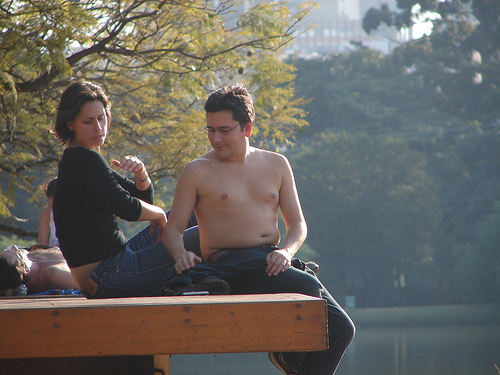

In [ ]:
try_image = test_img[0]
Image.open(try_image)


In [ ]:
print ('Normal Max search:', predict_captions(try_image)) 
print ('Beam Search, k=3:', beam_search_predictions(try_image, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(try_image, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(try_image, beam_index=7))

Normal Max search: A man in a yellow shirt sits on a cement and looking at a rock wall .
Beam Search, k=3: A man is sitting on the edge of a wooden dock under a blue sky .
Beam Search, k=5: A man and a blond boy are in high pool .
Beam Search, k=7: There is a man on a boat on the shore of a lake .


In [ ]:
try_image2 = test_img[5]
Image.open(try_image2)

In [ ]:
print ('Normal Max search:', predict_captions(try_image2)) 
print ('Beam Search, k=3:', beam_search_predictions(try_image2, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(try_image2, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(try_image2, beam_index=7))

In [ ]:
try_image3 = test_img[851]
Image.open(try_image3)

In [ ]:
print ('Normal Max search:', predict_captions(try_image3)) 
print ('Beam Search, k=3:', beam_search_predictions(try_image3, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(try_image3, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(try_image3, beam_index=7))

In [ ]:
try_image4 = '/content/drive/My Drive/dataset/Flickr8k/Flickr8k_Dataset/Flicker8k_Dataset/136552115_6dc3e7231c.jpg'
print ('Normal Max search:', predict_captions(try_image4))
print ('Beam Search, k=3:', beam_search_predictions(try_image4, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(try_image4, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(try_image4, beam_index=7))
Image.open(try_image4)

In [ ]:
im = '/content/drive/My Drive/dataset/Flickr8k/Flickr8k_Dataset/Flicker8k_Dataset/1674612291_7154c5ab61.jpg'
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im////, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)

NameError: ignored

In [ ]:
# im = 'Flickr8k_Dataset/Flicker8k_Dataset/3631986552_944ea208fc.jpg'
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)

In [ ]:
im = test_img[int(np.random.randint(0, 1000, size=1))]
print (im)
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)